In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torchvision import models
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
N = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=N, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=N, shuffle=False)

In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

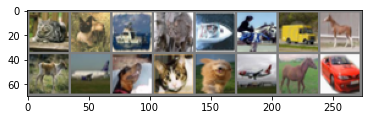

  cat   cat  ship   cat  ship horse truck horse  deer plane   dog   cat   dog plane horse   car


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(N)))

In [7]:
test = testloader.dataset.data[0]

In [8]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3,  # チャネル入力
                                     32,  # チャンネル出力
                                     3,  # カーネルサイズ
                                     1,  # ストライド (デフォルトは1)
                                     1,  # パディング (デフォルトは0)
                                     )
        self.conv2 = torch.nn.Conv2d(32, 32, 3,1,1)
        self.conv3 = torch.nn.Conv2d(32, 64, 3,1,1)
        self.conv4 = torch.nn.Conv2d(64, 64, 3,1,1)
        self.pool = torch.nn.MaxPool2d(2, 2)  # カーネルサイズ, ストライ
        self.fc1 = torch.nn.Linear(64*2*2, 256)  # 入力サイズ, 出力サイズ
        self.fc2 = torch.nn.Linear(256, 10)
        self.relu = nn.ReLU(inplace=True)
        self.dropout0 = torch.nn.Dropout2d(p=0.25)
        self.dropout2 = torch.nn.Dropout2d(p=0.45)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout0(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout0(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout0(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
 
        return x



In [9]:
net = CNN()

In [10]:
net

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
  (dropout0): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.45, inplace=False)
)

In [11]:
# ロス関数、最適化器の定義
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [12]:
# データセット内の全画像を10回使用するまでループ
for epoch in range(500):
    running_loss = 0

    # データセット内でループ
    for i, data in enumerate(trainloader, 0):
        # 入力バッチの読み込み (画像、正解ラベル)
        inputs, labels = data

        # 最適化器をゼロ初期化
        optimizer.zero_grad()

        # 入力画像をモデルに通して出力ラベルを取得
        outputs = net(inputs)

        # 正解との誤差の計算 + 誤差逆伝搬
        loss = loss_func(outputs, labels)
        loss.backward()

        # 誤差を用いてモデルの最適化
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

/home/yamada/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448216815/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  1000] loss: 2.148
[1,  2000] loss: 1.923
[1,  3000] loss: 1.821
[2,  1000] loss: 1.726
[2,  2000] loss: 1.694
[2,  3000] loss: 1.653
[3,  1000] loss: 1.615
[3,  2000] loss: 1.582
[3,  3000] loss: 1.551
[4,  1000] loss: 1.520
[4,  2000] loss: 1.481
[4,  3000] loss: 1.485
[5,  1000] loss: 1.459
[5,  2000] loss: 1.430
[5,  3000] loss: 1.414
[6,  1000] loss: 1.395
[6,  2000] loss: 1.377
[6,  3000] loss: 1.362
[7,  1000] loss: 1.342
[7,  2000] loss: 1.336
[7,  3000] loss: 1.318
[8,  1000] loss: 1.300
[8,  2000] loss: 1.286
[8,  3000] loss: 1.274
[9,  1000] loss: 1.245
[9,  2000] loss: 1.250
[9,  3000] loss: 1.250
[10,  1000] loss: 1.214
[10,  2000] loss: 1.216
[10,  3000] loss: 1.204
[11,  1000] loss: 1.189
[11,  2000] loss: 1.191
[11,  3000] loss: 1.181
[12,  1000] loss: 1.145
[12,  2000] loss: 1.150
[12,  3000] loss: 1.151
[13,  1000] loss: 1.130
[13,  2000] loss: 1.125
[13,  3000] loss: 1.115
[14,  1000] loss: 1.106
[14,  2000] loss: 1.094
[14,  3000] loss: 1.106
[15,  1000] loss: 1

[114,  3000] loss: 0.630
[115,  1000] loss: 0.624
[115,  2000] loss: 0.622
[115,  3000] loss: 0.646
[116,  1000] loss: 0.621
[116,  2000] loss: 0.642
[116,  3000] loss: 0.640
[117,  1000] loss: 0.622
[117,  2000] loss: 0.642
[117,  3000] loss: 0.641
[118,  1000] loss: 0.624
[118,  2000] loss: 0.639
[118,  3000] loss: 0.628
[119,  1000] loss: 0.625
[119,  2000] loss: 0.633
[119,  3000] loss: 0.630
[120,  1000] loss: 0.620
[120,  2000] loss: 0.626
[120,  3000] loss: 0.631
[121,  1000] loss: 0.629
[121,  2000] loss: 0.637
[121,  3000] loss: 0.640
[122,  1000] loss: 0.624
[122,  2000] loss: 0.636
[122,  3000] loss: 0.638
[123,  1000] loss: 0.619
[123,  2000] loss: 0.623
[123,  3000] loss: 0.636
[124,  1000] loss: 0.626
[124,  2000] loss: 0.624
[124,  3000] loss: 0.635
[125,  1000] loss: 0.628
[125,  2000] loss: 0.623
[125,  3000] loss: 0.628
[126,  1000] loss: 0.619
[126,  2000] loss: 0.620
[126,  3000] loss: 0.628
[127,  1000] loss: 0.618
[127,  2000] loss: 0.626
[127,  3000] loss: 0.634


[224,  1000] loss: 0.559
[224,  2000] loss: 0.572
[224,  3000] loss: 0.579
[225,  1000] loss: 0.566
[225,  2000] loss: 0.574
[225,  3000] loss: 0.561
[226,  1000] loss: 0.562
[226,  2000] loss: 0.576
[226,  3000] loss: 0.570
[227,  1000] loss: 0.577
[227,  2000] loss: 0.574
[227,  3000] loss: 0.565
[228,  1000] loss: 0.565
[228,  2000] loss: 0.564
[228,  3000] loss: 0.577
[229,  1000] loss: 0.575
[229,  2000] loss: 0.559
[229,  3000] loss: 0.566
[230,  1000] loss: 0.576
[230,  2000] loss: 0.565
[230,  3000] loss: 0.581
[231,  1000] loss: 0.568
[231,  2000] loss: 0.575
[231,  3000] loss: 0.574
[232,  1000] loss: 0.571
[232,  2000] loss: 0.550
[232,  3000] loss: 0.575
[233,  1000] loss: 0.567
[233,  2000] loss: 0.559
[233,  3000] loss: 0.568
[234,  1000] loss: 0.570
[234,  2000] loss: 0.574
[234,  3000] loss: 0.572
[235,  1000] loss: 0.569
[235,  2000] loss: 0.565
[235,  3000] loss: 0.565
[236,  1000] loss: 0.570
[236,  2000] loss: 0.567
[236,  3000] loss: 0.569
[237,  1000] loss: 0.559


[333,  2000] loss: 0.545
[333,  3000] loss: 0.535
[334,  1000] loss: 0.540
[334,  2000] loss: 0.554
[334,  3000] loss: 0.545
[335,  1000] loss: 0.542
[335,  2000] loss: 0.531
[335,  3000] loss: 0.544
[336,  1000] loss: 0.529
[336,  2000] loss: 0.544
[336,  3000] loss: 0.550
[337,  1000] loss: 0.543
[337,  2000] loss: 0.529
[337,  3000] loss: 0.550
[338,  1000] loss: 0.538
[338,  2000] loss: 0.548
[338,  3000] loss: 0.538
[339,  1000] loss: 0.536
[339,  2000] loss: 0.538
[339,  3000] loss: 0.535
[340,  1000] loss: 0.549
[340,  2000] loss: 0.542
[340,  3000] loss: 0.540
[341,  1000] loss: 0.552
[341,  2000] loss: 0.545
[341,  3000] loss: 0.531
[342,  1000] loss: 0.535
[342,  2000] loss: 0.538
[342,  3000] loss: 0.542
[343,  1000] loss: 0.534
[343,  2000] loss: 0.534
[343,  3000] loss: 0.545
[344,  1000] loss: 0.542
[344,  2000] loss: 0.535
[344,  3000] loss: 0.541
[345,  1000] loss: 0.534
[345,  2000] loss: 0.540
[345,  3000] loss: 0.535
[346,  1000] loss: 0.521
[346,  2000] loss: 0.546


[442,  3000] loss: 0.520
[443,  1000] loss: 0.512
[443,  2000] loss: 0.525
[443,  3000] loss: 0.537
[444,  1000] loss: 0.525
[444,  2000] loss: 0.518
[444,  3000] loss: 0.540
[445,  1000] loss: 0.504
[445,  2000] loss: 0.506
[445,  3000] loss: 0.536
[446,  1000] loss: 0.517
[446,  2000] loss: 0.525
[446,  3000] loss: 0.526
[447,  1000] loss: 0.508
[447,  2000] loss: 0.516
[447,  3000] loss: 0.532
[448,  1000] loss: 0.518
[448,  2000] loss: 0.514
[448,  3000] loss: 0.532
[449,  1000] loss: 0.503
[449,  2000] loss: 0.516
[449,  3000] loss: 0.526
[450,  1000] loss: 0.512
[450,  2000] loss: 0.542
[450,  3000] loss: 0.522
[451,  1000] loss: 0.515
[451,  2000] loss: 0.528
[451,  3000] loss: 0.530
[452,  1000] loss: 0.519
[452,  2000] loss: 0.508
[452,  3000] loss: 0.535
[453,  1000] loss: 0.510
[453,  2000] loss: 0.527
[453,  3000] loss: 0.526
[454,  1000] loss: 0.530
[454,  2000] loss: 0.510
[454,  3000] loss: 0.537
[455,  1000] loss: 0.531
[455,  2000] loss: 0.509
[455,  3000] loss: 0.519


In [13]:
%%time
# 4. テスト
ans = []
pred = []
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    outputs = net(inputs)

    ans += labels.tolist()
    pred += torch.argmax(outputs, 1).tolist()

print('accuracy:', accuracy_score(ans, pred))
print('confusion matrix:')
print(confusion_matrix(ans, pred))

accuracy: 0.7259
confusion matrix:
[[762  18  47  21  11  10   5  14  66  46]
 [ 18 856   2   8   1   3   5   4  21  82]
 [ 73   5 581  55  73  68  72  44  15  14]
 [ 28   9  49 538  68 169  73  35  11  20]
 [ 21   1  61  68 692  27  46  70   7   7]
 [ 12   2  51 182  36 605  21  72   9  10]
 [  9   5  36  70  41  27 792  10   8   2]
 [ 16   1  29  34  51  61   6 783   1  18]
 [ 74  38   9  17   5   6   6   9 806  30]
 [ 25  74   3   9   3   6   2  18  16 844]]
CPU times: user 1min 29s, sys: 52.9 ms, total: 1min 29s
Wall time: 3.75 s
